# Imports

In [54]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
import matplotlib.pyplot as plt

# Pre-Processing

In [55]:
# Load and combine data
PATH_TO_FILE_1 = "../raw data/aapl_2016_2020.csv"
PATH_TO_FILE_2 = "../raw data/aapl_2021_2023.csv"
half_1 = pd.read_csv(PATH_TO_FILE_1, low_memory=False)
half_2 = pd.read_csv(PATH_TO_FILE_2, low_memory=False)
df = pd.concat([half_1, half_2], ignore_index=True)
df.columns = df.columns.str.strip()

# Option type
option_type = "call"

# Convert Unix timestamps to datetime
df['QUOTE_DATETIME'] = pd.to_datetime(df['[QUOTE_UNIXTIME]'], unit='s')
df['EXPIRE_DATETIME'] = pd.to_datetime(df['[EXPIRE_UNIX]'], unit='s')

# Load underlying price data for volatility computation
underlying_prices = df[['QUOTE_DATETIME', '[UNDERLYING_LAST]']].drop_duplicates().set_index('QUOTE_DATETIME').sort_index()

# Function to compute historical volatility
def historical_volatility(series, window=20):
    return np.sqrt(252) * series.pct_change().rolling(window=window).std()

# Compute 20-day historical volatility
underlying_prices['hist_vol_20d'] = historical_volatility(underlying_prices['[UNDERLYING_LAST]'])
underlying_prices.dropna(inplace=True)

# Merge historical volatility back into main dataframe
df = df.merge(underlying_prices[['hist_vol_20d']], left_on='QUOTE_DATETIME', right_index=True, how='inner')

# Columns to numeric conversion: choose columns based on option type
if option_type == 'call':
    numeric_cols = ['[UNDERLYING_LAST]', '[DTE]', '[STRIKE]', '[C_DELTA]', '[C_GAMMA]', '[C_VEGA]',
                    '[C_THETA]', '[C_RHO]', '[C_BID]', '[C_ASK]']
else:
    numeric_cols = ['[UNDERLYING_LAST]', '[DTE]', '[STRIKE]', '[P_DELTA]', '[P_GAMMA]', '[P_VEGA]',
                    '[P_THETA]', '[P_RHO]', '[P_BID]', '[P_ASK]']

essential_cols = ['[UNDERLYING_LAST]', '[DTE]', '[STRIKE]', 'hist_vol_20d', '[C_BID]', '[C_ASK]']
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')
df.dropna(subset=essential_cols, inplace=True)

# Calculate mid-price based on option type
if option_type == 'call':
    df['CALL_EQUI_PRICE'] = (df['[C_BID]'] + df['[C_ASK]']) / 2
else:
    df['PUT_EQUI_PRICE'] = (df['[P_BID]'] + df['[P_ASK]']) / 2

# Drop rows with missing essential data (dynamically chosen based on option type)
essential_cols = ['[UNDERLYING_LAST]', '[DTE]', '[STRIKE]', 'hist_vol_20d']
if option_type == 'call':
    essential_cols.append('CALL_EQUI_PRICE')
else:
    essential_cols.append('PUT_EQUI_PRICE')
df.dropna(subset=essential_cols, inplace=True)

# Prepare option data based on the option type
if option_type == 'call':
    option_cols = ['[UNDERLYING_LAST]', '[STRIKE]', '[DTE]', 'hist_vol_20d', 
                   '[C_DELTA]', '[C_GAMMA]', '[C_VEGA]', '[C_THETA]', '[C_RHO]', 'CALL_EQUI_PRICE']
    col_rename = ['underlying_price', 'strike_price', 'days_to_expiry', 'hist_volatility', 
                  'delta', 'gamma', 'vega', 'theta', 'rho', 'equilibrium_price']
    output_file = 'processed_calls_data.csv'
    model_file = 'call-mlp1.h5'
else:
    option_cols = ['[UNDERLYING_LAST]', '[STRIKE]', '[DTE]', 'hist_vol_20d', 
                   '[P_DELTA]', '[P_GAMMA]', '[P_VEGA]', '[P_THETA]', '[P_RHO]', 'PUT_EQUI_PRICE']
    col_rename = ['underlying_price', 'strike_price', 'days_to_expiry', 'hist_volatility', 
                  'delta', 'gamma', 'vega', 'theta', 'rho', 'equilibrium_price']
    output_file = 'processed_puts_data.csv'
    model_file = 'put-mlp1.h5'

option_df = df[option_cols].copy()
option_df.columns = col_rename

# Normalize strike price and compute time to expiry in years
option_df['strike_price'] = option_df['strike_price'] / 1000
option_df['time_to_expiry'] = option_df['days_to_expiry'] / 365
option_df.drop('days_to_expiry', axis=1, inplace=True)

print(option_df.sample(10))

         underlying_price  strike_price  hist_volatility    delta    gamma  \
286955             292.69        0.4600         0.349159  0.00218  0.00013   
216362             204.23        0.2750         0.180677  0.00143  0.00015   
339569             200.08        0.0900         0.200199  0.87820  0.00022   
1371820            145.92        0.1775         0.259444  0.00598  0.00152   
1064468            132.30        0.2050         0.341310  0.20338  0.00560   
817061             153.93        0.2500         0.192145  0.02704  0.00173   
774047             200.99        0.1700         0.289970  0.96902  0.00386   
459506             179.26        0.1300         0.154024  0.81820  0.00290   
547498             190.89        0.2200         0.157796  0.27996  0.00806   
1375232            151.62        0.0750         0.246404  1.00000  0.00000   

            vega    theta      rho  equilibrium_price  time_to_expiry  
286955   0.00684 -0.00278  0.00047              0.025        0.139616

# Hyperparameters

In [56]:
# Hyperparameters
n_units_per_layer = [256, 32, 1]
layers = 3
n_batch = 1024
n_epochs = 50

# Building model

In [57]:
# Prepare data for modeling
X = option_df[['underlying_price', 'strike_price', 'hist_volatility', 'delta', 'gamma', 'vega', 'theta', 'rho', 'time_to_expiry']]
y = option_df['equilibrium_price']


# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create model 
model = Sequential()


# Scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Add first layer without ativation
model.add(Dense(n_units_per_layer[0], input_shape=(X_train_scaled.shape[1],)))
model.add(Activation('relu'))

# Define Keras MLP model using LeakyReLU in subsequent layers
for i in range(1, layers - 1):
    model.add(Dense(n_units_per_layer[i]))
    model.add(Activation('relu'))

# Add last layer
model.add(Dense(n_units_per_layer[-1]))
model.add(Activation('relu'))

# Learning rate scheduling
def scheduler(epoch, lr):
    if epoch % 10 == 0 and epoch != 0:
        return lr * 0.1  # reduce LR by 10x every 10 epochs
    return lr

lr_callback = LearningRateScheduler(scheduler)

early_stop = EarlyStopping(
    monitor='val_loss',       # what to monitor
    patience=5,               # how many epochs to wait before stopping
    restore_best_weights=True,  # restores weights from best epoch
    verbose=1
)

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
model.summary()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                │ (None, 256)            │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_15 (Activation)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_16 (Activation)      │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1)              │            33 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_17 (Activation)      │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,817 (42.25 KB)

 Trainable params: 10,817 (42.25 KB)

 Non-trainable params: 0 (0.00 B)

# Train model

In [58]:
# Train the model
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, batch_size=n_batch, validation_split=0.2, verbose=1, callbacks=[lr_callback, early_stop])

# Evaluate the model
loss, mae = model.evaluate(X_test_scaled, y_test)
print(f"Test MAE: {mae}")

# Save the model
model.save(model_file)

Epoch 1/50
969/969 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 948.2515 - mae: 13.7498 - val_loss: 3.8940 - val_mae: 1.2385 - learning_rate: 0.0010
Epoch 2/50
969/969 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.2731 - mae: 1.0873 - val_loss: 2.0227 - val_mae: 0.7699 - learning_rate: 0.0010
Epoch 3/50
969/969 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.8489 - mae: 0.7066 - val_loss: 1.3313 - val_mae: 0.5540 - learning_rate: 0.0010
Epoch 4/50
969/969 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.3632 - mae: 0.5354 - val_loss: 1.0459 - val_mae: 0.4576 - learning_rate: 0.0010
Epoch 5/50
969/969 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.0625 - mae: 0.4483 - val_loss: 1.1121 - val_mae: 0.5420 - learning_rate: 0.0010
Epoch 6/50
969/969 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.0484 - mae: 0.4063 - val_loss: 0.8244 - val_mae: 0.3920 - learning_rate: 0.0010
Epoch 7/50
969/969 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.8014 - mae: 0.3685 - val_loss: 0.9058 - val_mae: 0.3668 - learning_rate: 0.0010
Epo

Test MAE: 0.2553163766860962


# Plot the loss

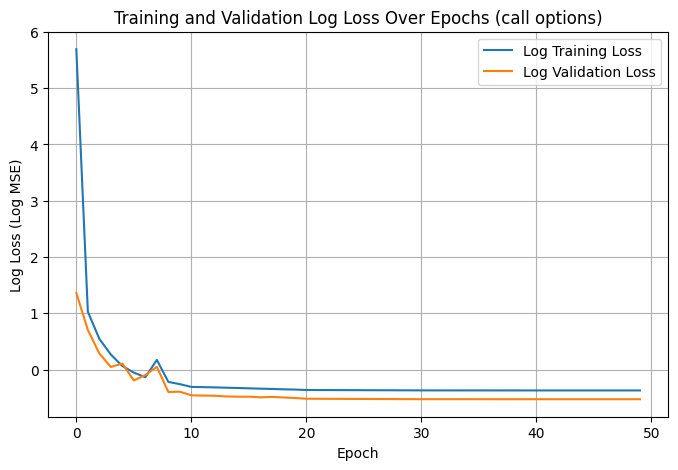

In [59]:
# Plot training and validation loss
plt.figure(figsize=(8,5))

eps = 1e-10  # tiny number to avoid log(0)
plt.plot(np.log(np.array(history.history['loss']) + eps), label='Log Training Loss')
plt.plot(np.log(np.array(history.history['val_loss']) + eps), label='Log Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Log Loss (Log MSE)')
plt.title(f'Training and Validation Log Loss Over Epochs ({option_type} options)')
plt.legend()
plt.grid(True)
plt.show()

# Plot results

9685/9685 ━━━━━━━━━━━━━━━━━━━━ 3s 261us/step


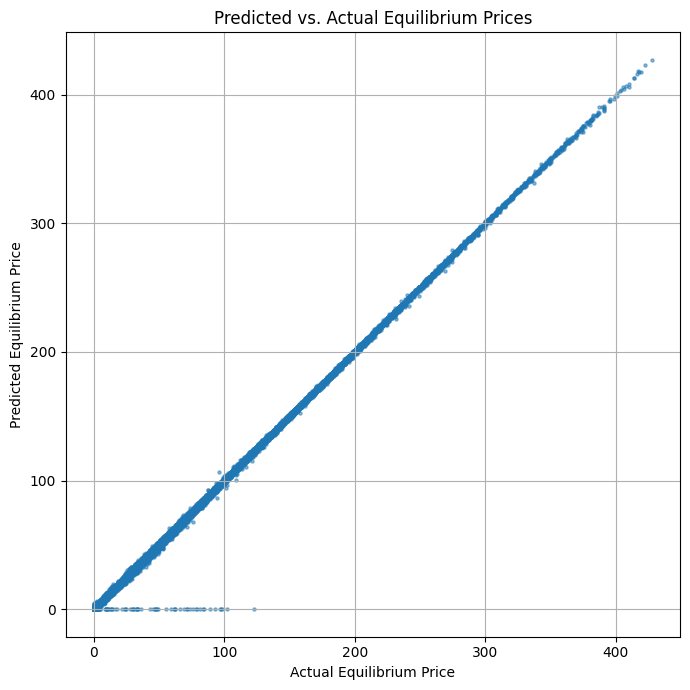

In [60]:
loaded_model = load_model(model_file)

# Predict on test set
y_pred = model.predict(X_test_scaled).flatten()

# Align y_test to numpy array with matching shape
y_test_array = y_test.to_numpy().flatten()

# Plot predicted vs actual
plt.figure(figsize=(7, 7))
plt.scatter(y_test_array, y_pred, s=5, alpha=0.5)
plt.xlabel('Actual Equilibrium Price')
plt.ylabel('Predicted Equilibrium Price')
plt.title('Predicted vs. Actual Equilibrium Prices')
plt.grid(True)
plt.tight_layout()
plt.show()

# Test random entries

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Entry 838459 - Predicted price: 0.15, Actual price: 0.40
Entry 724473 - Predicted price: 40.31, Actual price: 40.10
Entry 952976 - Predicted price: 66.48, Actual price: 65.70
Entry 213786 - Predicted price: 0.00, Actual price: 0.01
Entry 1420582 - Predicted price: 1.29, Actual price: 1.42
Entry 29536 - Predicted price: 25.76, Actual price: 25.80
Entry 1089995 - Predicted price: 40.39, Actual price: 40.78
Entry 448431 - Predicted price: 0.00, Actual price: 0.07
Entry 988039 - Predicted price: 355.12, Actual price: 354.56
Entry 651712 - Predicted price: 8.55, Actual price: 8.75


9685/9685 ━━━━━━━━━━━━━━━━━━━━ 2s 255us/step


/var/folders/bk/_nfh05pn5y1bcz9mw5l6lhs80000gn/T/ipykernel_19173/708158378.py:16: RuntimeWarning: divide by zero encountered in divide
  percent_errors = 100 * (y_pred - y_true) / y_true
/var/folders/bk/_nfh05pn5y1bcz9mw5l6lhs80000gn/T/ipykernel_19173/708158378.py:16: RuntimeWarning: invalid value encountered in divide
  percent_errors = 100 * (y_pred - y_true) / y_true


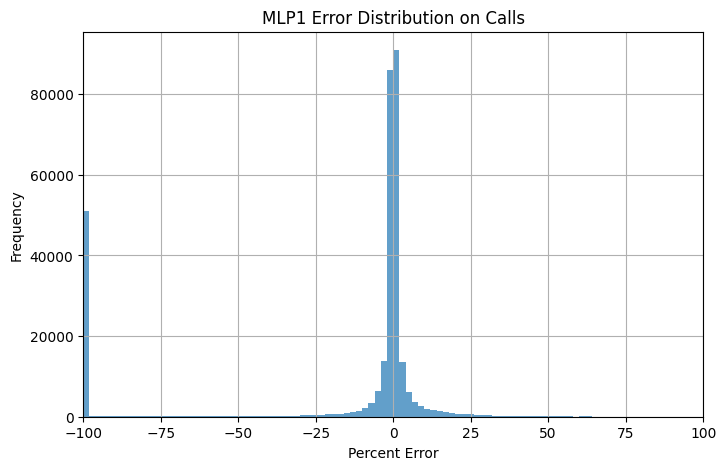

In [63]:
# Test 10 random entries
loaded_model = load_model(model_file)
sample_entries = X.sample(10)
sample_scaled = scaler.transform(sample_entries)
predictions = loaded_model.predict(sample_scaled)

for i, idx in enumerate(sample_entries.index):
    print(f"Entry {idx} - Predicted price: {predictions[i][0]:.2f}, Actual price: {y.loc[idx]:.2f}")

# ---- Full Test Set Error Analysis ----
X_test_scaled = scaler.transform(X_test)
y_pred = loaded_model.predict(X_test_scaled).flatten()
y_true = y_test.values

# Compute percent errors
percent_errors = 100 * (y_pred - y_true) / y_true

bins = np.arange(-200, 201, 2)  # from -100 to +100 with 2% width

# Plot histogram with x-axis limited to [-100%, 100%]
plt.figure(figsize=(8, 5))
plt.hist(percent_errors, bins=bins, alpha=0.7)
plt.xlabel("Percent Error")
plt.ylabel("Frequency")
plt.title("MLP1 Error Distribution on Calls")
plt.xlim([-100, 100])
plt.grid(True)
plt.show()